## Load Data

In [1]:
import requests

def download_file(url, filename):
  try:
    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(filename, 'wb') as file:
      for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
    print(f"File downloaded successfully to {filename}")

  except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}")

url = "https://drive.usercontent.google.com/download?id=1dkVf3x5XwdU1grpIEmCeLgIJ-fyHHX_E&export=download&authuser=0&confirm=t&uuid=3f6a4936-af5f-42ed-a968-1b5454e5a509&at=AENtkXaECaZRgRQzum6YGkwspoVB%3A1732511691248"
filename = "CHB-MIT Scalp EEG Database.rar"
download_file(url, filename)

File downloaded successfully to CHB-MIT Scalp EEG Database.rar


In [2]:
!mkdir /content/dataset
!unrar x '/content/CHB-MIT Scalp EEG Database.rar' '/content/dataset'


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/CHB-MIT Scalp EEG Database.rar

Creating    /content/dataset/Sub16                                    OK
Extracting  /content/dataset/Sub16/chb16-summary.txt                       0%  OK 
Creating    /content/dataset/Sub16/WOS16                              OK
Extracting  /content/dataset/Sub16/WOS16/chb16_07.edf                      0%  1%  2%  OK 
Creating    /content/dataset/Sub16/WS16                               OK
Extracting  /content/dataset/Sub16/WS16/chb16_10.edf                       3%  4%  5%  6%  OK 
Extracting  /content/dataset/Sub16/WS16/chb16_11.edf                       7%  8%  9%  OK 
Extracting  /content/dataset/Sub16/WS16/chb16_14.edf                      10% 11% 12%  OK 
Extracting  /content/dataset/Sub16/WS16/chb16_16.edf                      13% 14% 15% 16%  OK 


In [3]:
!pip install pyedflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 46.7 MB/s eta 0:00:00


## Read Data

In [4]:
import pyedflib
import numpy as np
import os
import re
import random

In [5]:
def load_edf(file_path):
    try:
        f = pyedflib.EdfReader(file_path)
        num_signals = f.signals_in_file
        sample_rate = f.getSampleFrequency(0)

        signals = []
        for i in range(num_signals):
            signal = f.readSignal(i)
            signals.append(signal)

        return np.array(signals), sample_rate
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

In [6]:
def load_data(dataset_root):
    seizure_trials = []
    non_seizure_trials = []
    summary_content = []

    for subject_dir in os.listdir(dataset_root):
        subject_path = os.path.join(dataset_root, subject_dir)

        if os.path.isdir(subject_path):
            summary_file = None
            for file_name in os.listdir(subject_path):
                if file_name.endswith("-summary.txt"):
                    summary_file = os.path.join(subject_path, file_name)
                    break

            if summary_file:
                with open(summary_file, 'r') as f:
                    summary_content.append(f.read())


            for folder_name in os.listdir(subject_path):
                if re.match(r"(WS|WOS)\d+", folder_name):
                    folder_path = os.path.join(subject_path, folder_name)

                    label = 1 if folder_name.startswith('WS') else 0
                    for edf_file in os.listdir(folder_path):
                        if edf_file.endswith('.edf'):
                            file_path = os.path.join(folder_path, edf_file)
                            signals, sample_rate = load_edf(file_path)

                            if signals is not None:
                                if label == 1:
                                    seizure_trials.append((signals, sample_rate, edf_file))
                                else:
                                    non_seizure_trials.append((signals, sample_rate, edf_file))


    all_trials = {}
    all_trials['Seizure'] = seizure_trials
    all_trials['Non-Seizure'] = non_seizure_trials
    all_trials['Summary'] = summary_content
    return all_trials

In [7]:
dataset_root = '/content/dataset'
trials = {}
trials = load_data(dataset_root)

In [8]:
print(len(trials['Seizure']))
print(len(trials['Non-Seizure']))
print(len(trials['Summary']))

26
5
5


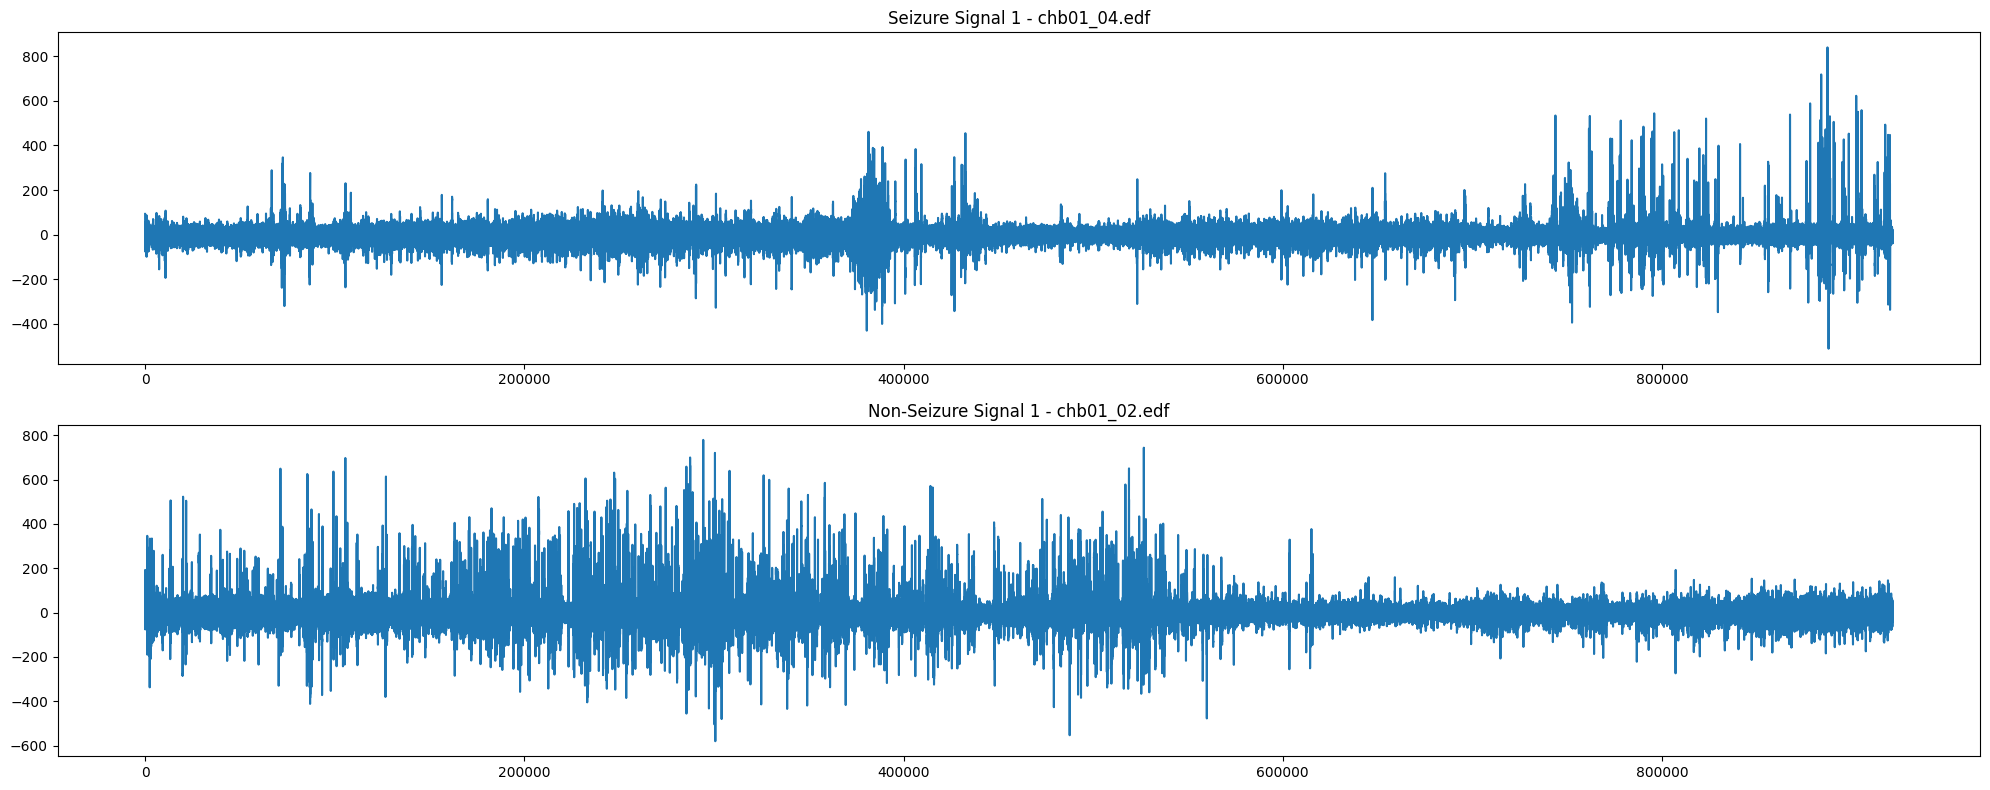

In [9]:
import matplotlib.pyplot as plt

def plot_signals(trials, num_plots=1):
    seizure_trials = trials['Seizure']
    non_seizure_trials = trials['Non-Seizure']

    plt.figure(figsize=(20, 8))

    for i in range(min(num_plots, len(seizure_trials))):
      signals, sample_rate, file_name= seizure_trials[i]
      plt.subplot(2, num_plots, i + 1)
      plt.plot(signals[0])
      plt.title(f"Seizure Signal {i+1} - {file_name}")

    for i in range(min(num_plots, len(non_seizure_trials))):
      signals, sample_rate, file_name = non_seizure_trials[i]
      plt.subplot(2, num_plots, i + 1 + num_plots)
      plt.plot(signals[0])
      plt.title(f"Non-Seizure Signal {i+1} - {file_name}")

    plt.tight_layout()
    plt.show()

plot_signals(trials)

## Segmentation

In [10]:
records = []
for item in trials['Seizure']:
  records.append(item[2])
for item in trials['Non-Seizure']:
  records.append(item[2])

print(records)

['chb01_04.edf', 'chb01_03.edf', 'chb01_26.edf', 'chb01_18.edf', 'chb01_15.edf', 'chb01_16.edf', 'chb08_13.edf', 'chb08_21.edf', 'chb08_05.edf', 'chb08_11.edf', 'chb08_02.edf', 'chb16_14.edf', 'chb16_11.edf', 'chb16_16.edf', 'chb16_10.edf', 'chb03_35.edf', 'chb03_34.edf', 'chb03_02.edf', 'chb03_36.edf', 'chb03_04.edf', 'chb14_06.edf', 'chb14_11.edf', 'chb14_18.edf', 'chb14_03.edf', 'chb14_27.edf', 'chb14_17.edf', 'chb01_02.edf', 'chb08_17.edf', 'chb16_07.edf', 'chb03_17.edf', 'chb14_20.edf']


In [11]:
def process_summary(summaries, records):
  output = []

  for summary in summaries:
    lines = summary.split('\n\n')
    for line in lines:
      for record in records:
        if record in line:
          output.append((line, record))

  return output

In [12]:
valid_summary = process_summary(trials['Summary'], records)

print(len(valid_summary))

31


In [13]:
for item in valid_summary:
  print(item)

('File Name: chb01_02.edf\nFile Start Time: 12:42:57\nFile End Time: 13:42:57\nNumber of Seizures in File: 0', 'chb01_02.edf')
('File Name: chb01_03.edf\nFile Start Time: 13:43:04\nFile End Time: 14:43:04\nNumber of Seizures in File: 1\nSeizure Start Time: 2996 seconds\nSeizure End Time: 3036 seconds', 'chb01_03.edf')
('File Name: chb01_04.edf\nFile Start Time: 14:43:12\nFile End Time: 15:43:12\nNumber of Seizures in File: 1\nSeizure Start Time: 1467 seconds\nSeizure End Time: 1494 seconds', 'chb01_04.edf')
('File Name: chb01_15.edf\nFile Start Time: 01:44:44\nFile End Time: 2:44:44\nNumber of Seizures in File: 1\nSeizure Start Time: 1732 seconds\nSeizure End Time: 1772 seconds', 'chb01_15.edf')
('File Name: chb01_16.edf\nFile Start Time: 02:44:51\nFile End Time: 3:44:51\nNumber of Seizures in File: 1\nSeizure Start Time: 1015 seconds\nSeizure End Time: 1066 seconds', 'chb01_16.edf')
('File Name: chb01_18.edf\nFile Start Time: 04:45:06\nFile End Time: 5:45:06\nNumber of Seizures in Fil

In [14]:
def crop_signal(item):
  for item2 in valid_summary:

    if item[2] == item2[1]:
      line = item2[0].split('\n')
      start_time = 0

      for word in line:
        if 'Seizure Start Time:' in word:
          start_time = int(word.removeprefix('Seizure Start Time: ').removesuffix('seconds'))
        elif 'Seizure 1 Start Time:' in word:
          start_time = int(word.removeprefix('Seizure 1 Start Time: ').removesuffix('seconds'))

      s = 0
      if (start_time-600) > 0 :
        s = (start_time-600)

      start_index = int(s * item[1])
      end_index = int(start_time * item[1])

      output = []
      for i in item[0]:
        output.append(i[start_index:end_index])

      return output


In [15]:
for i in range(len(trials['Seizure'])):
    trials['Seizure'][i] = (crop_signal(trials['Seizure'][i]), trials['Seizure'][i][1], trials['Seizure'][i][2])

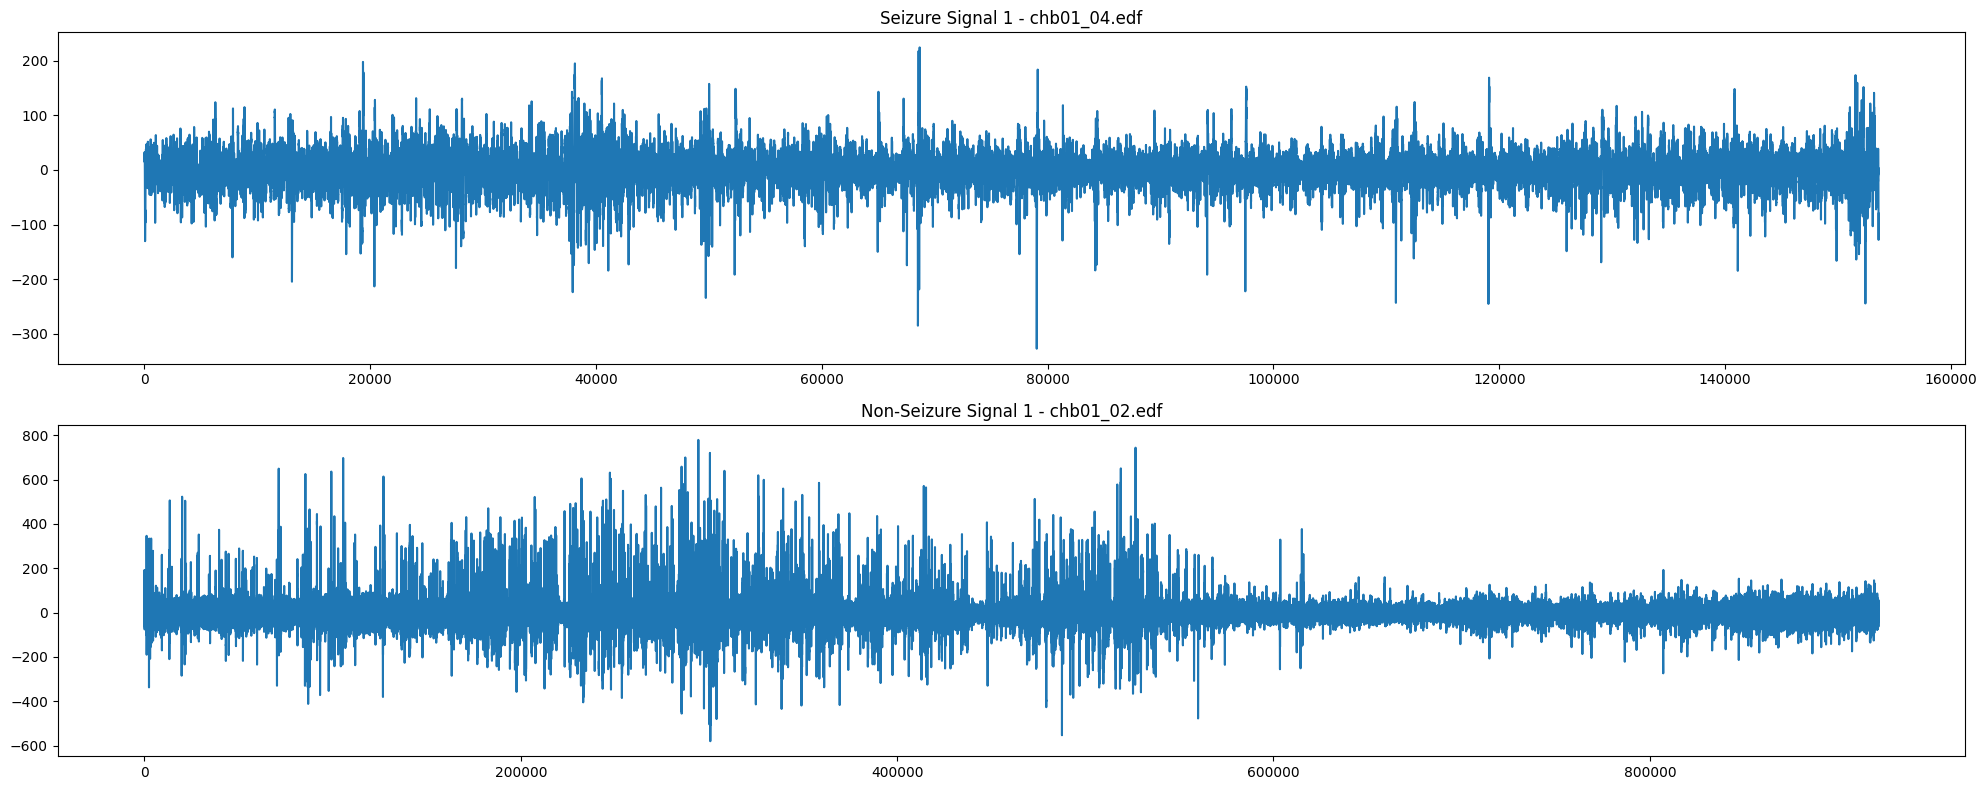

In [16]:
plot_signals(trials)

In [17]:
import random
import re

def peak_and_balance(trials, segment_length_seconds=600):
    seizure_trials = trials['Seizure']
    non_seizure_trials = trials['Non-Seizure']

    balanced_non_seizure_trials = []

    # Group non-seizure trials by subject (chbXX)
    non_seizure_by_subject = {}
    for trial in non_seizure_trials:
        file_name = trial[2]
        subject = re.search(r'chb(\d+)', file_name).group(0)  # Extract chbXX
        if subject not in non_seizure_by_subject:
            non_seizure_by_subject[subject] = []
        non_seizure_by_subject[subject].append(trial)

    # Select non-seizure trials based on corresponding seizure file names
    for seizure_trial in seizure_trials:
        seizure_file_name = seizure_trial[2]
        subject = re.search(r'chb(\d+)', seizure_file_name).group(0)  # Extract chbXX

        if subject in non_seizure_by_subject:
            # Randomly select a non-seizure trial from the same subject
            selected_trial = random.choice(non_seizure_by_subject[subject])
            balanced_non_seizure_trials.append(selected_trial)
        else:
            print(f"Warning: No non-seizure trials found for subject {subject}. Skipping.")

    peaked_non_seizure = []
    for trial in balanced_non_seizure_trials:
        signals, sample_rate, file_name = trial
        segment_length_samples = int(segment_length_seconds * sample_rate)

        if len(signals[0]) >= segment_length_samples:
            start_index = random.randint(0, len(signals[0]) - segment_length_samples)
            end_index = start_index + segment_length_samples
            segmented_signals = []
            for signal in signals:
                segmented_signals.append(signal[start_index:end_index])
            peaked_non_seizure.append((segmented_signals, sample_rate, file_name))
        else:
            print(f"Warning: Non-seizure trial {file_name} is shorter than the segment length. Skipping.")

    trials['Non-Seizure'] = peaked_non_seizure
    return trials

In [18]:
trials = peak_and_balance(trials)

In [19]:
print(len(trials['Seizure']))
print(len(trials['Non-Seizure']))

26
26


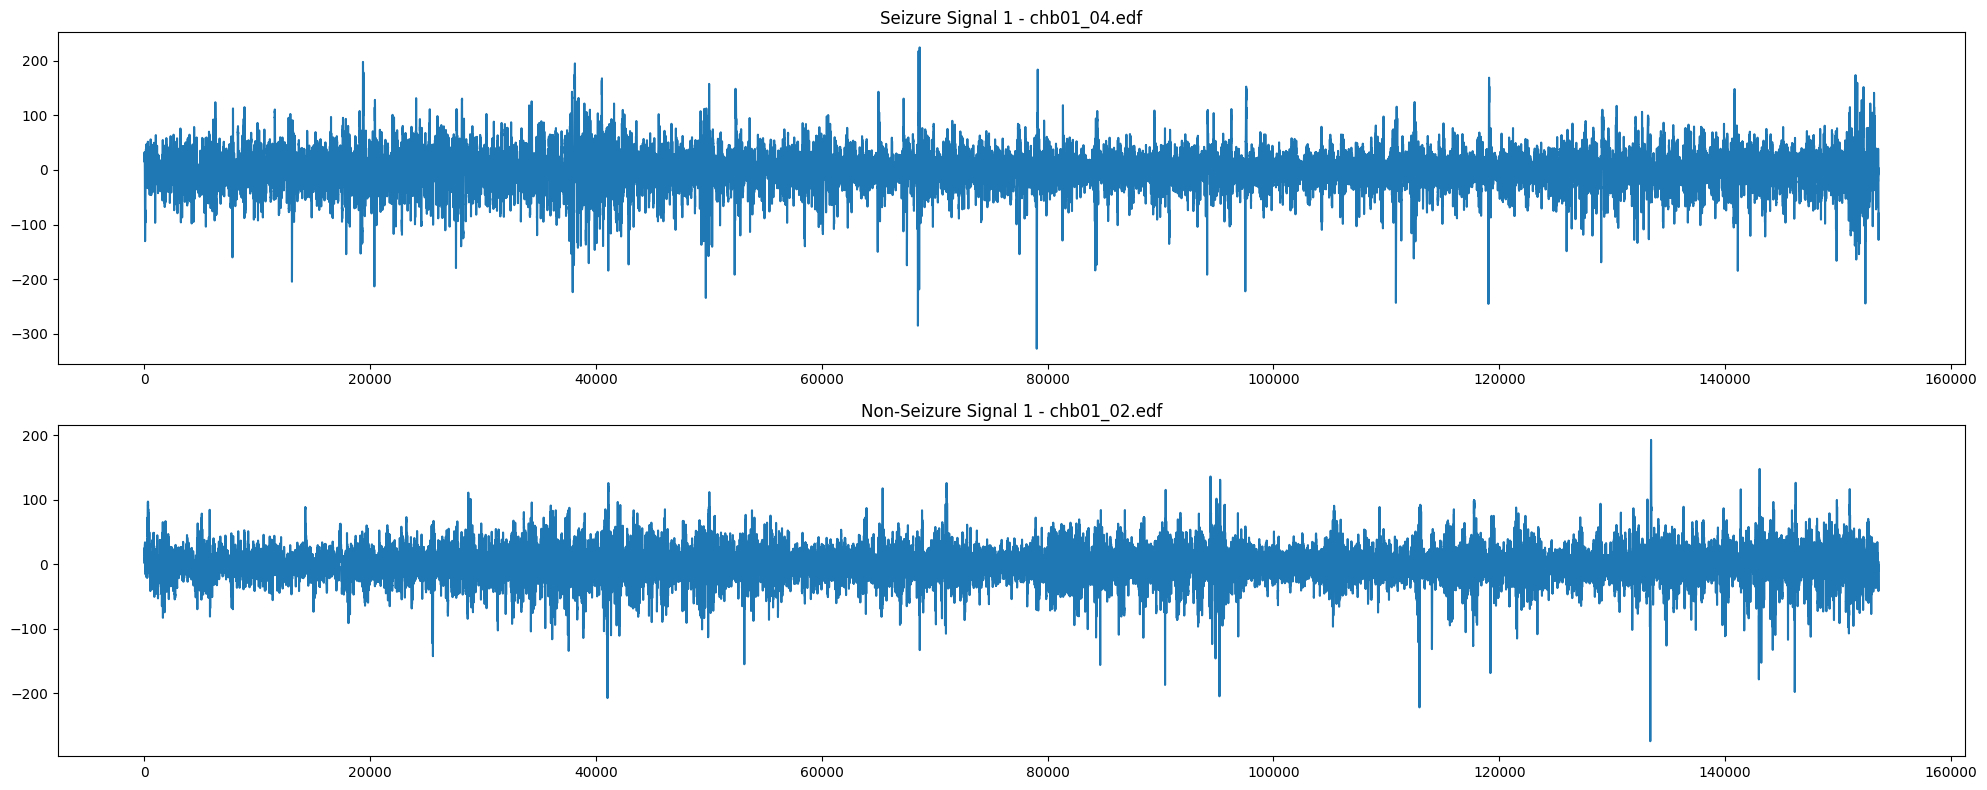

In [20]:
plot_signals(trials)

## Preprocessing

In [21]:
def extract_epochs(signal, segment_start_idx, sample_rate, epoch_duration=16):
    # Calculate number of samples for each epoch (16 seconds)
    epoch_samples = epoch_duration * int(sample_rate)

    # Extract epochs from the first 9 minutes (540 seconds)
    # Convert sample_rate to an integer here as well
    segment_end_idx = segment_start_idx + 9 * 60 * int(sample_rate)  # 9 minutes from the start
    epochs = []
    for i in range(0, segment_end_idx - segment_start_idx, epoch_samples):
        epoch = signal[i:i + epoch_samples]
        if len(epoch) == epoch_samples:  # Ensure full epoch
            epochs.append(epoch)

    return epochs

In [22]:
def preprocess_data(trials):
    processed_trials = {}

    for item in trials:
        signals = item[0]
        sample_rate = item[1]
        file_name = item[2]

        file_name = file_name[:-7]

        for signal in signals:
            segment_start_idx = 0
            epochs = extract_epochs(signal, segment_start_idx, sample_rate)
            if file_name not in processed_trials:
                processed_trials[file_name] = epochs
            else:
                processed_trials[file_name].extend(epochs)

    return processed_trials

In [23]:
s_epochs = preprocess_data(trials['Seizure'])
ns_epochs = preprocess_data(trials['Non-Seizure'])

In [24]:
print(len(s_epochs))
print(len(ns_epochs))

5
5


In [25]:
print(s_epochs.keys())
print(ns_epochs.keys())

dict_keys(['chb01', 'chb08', 'chb16', 'chb03', 'chb14'])
dict_keys(['chb01', 'chb08', 'chb16', 'chb03', 'chb14'])


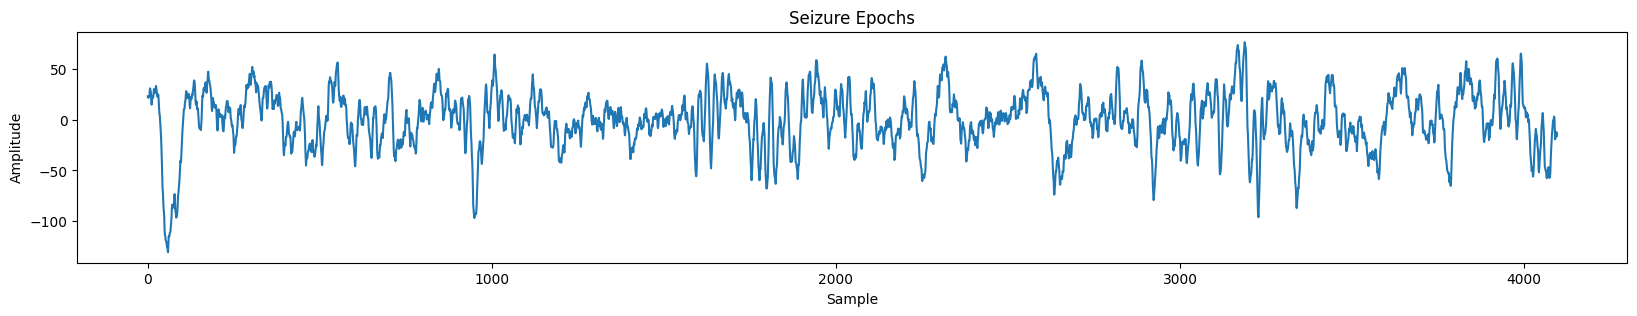

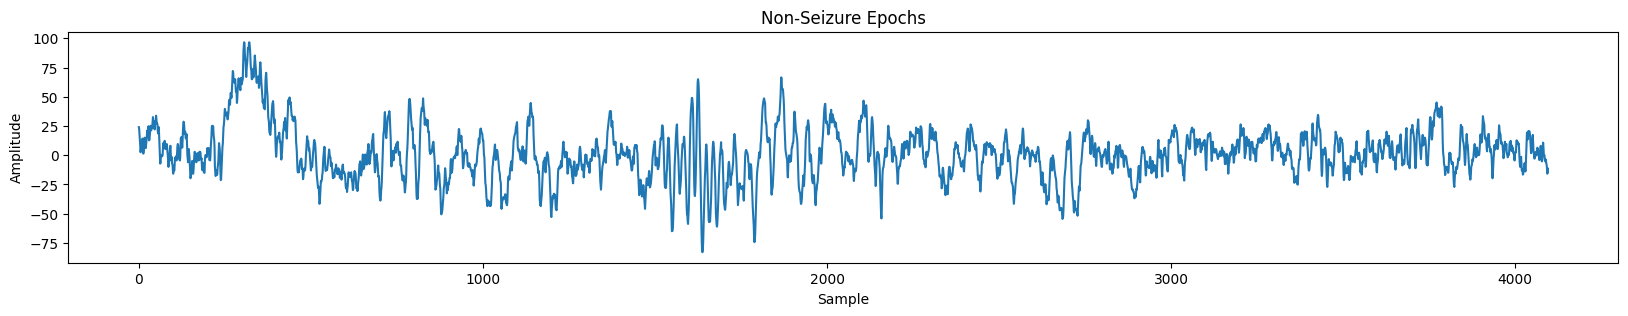

In [26]:
def plot_epochs(epoch, title="Epochs"):
    plt.figure(figsize=(20, 3))
    plt.plot(epoch)
    plt.title(title)
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()


plot_epochs(list(s_epochs.values())[0][0], "Seizure Epochs")
plot_epochs(list(ns_epochs.values())[0][0], "Non-Seizure Epochs")

In [27]:
# free some memory :|
trials = {}

## Feature Extraction

In [28]:
def shannon_entropy(signal):
    prob_dist, _ = np.histogram(signal, bins=256, density=True)
    prob_dist = prob_dist[prob_dist > 0]
    entropy = -np.sum(prob_dist * np.log2(prob_dist))
    return entropy

In [29]:
def extract_statistics(signal):
    stats = {
        'mean': np.mean(signal),
        'variance': np.var(signal),
        'min': np.min(signal),
        'max': np.max(signal)
    }
    return stats

In [30]:
from scipy.stats import zscore

def normalize_features(features):
    return zscore(features, axis=0)

In [31]:
from scipy.stats import ttest_ind

def select_features(features, labels, p_threshold=0.01):
    selected_features = []
    num_features = features.shape[1]

    for i in range(num_features):
        seizure_features = features[labels == 1, i]
        non_seizure_features = features[labels == 0, i]

        t_stat, p_value = ttest_ind(seizure_features, non_seizure_features)

        if p_value < p_threshold:
            selected_features.append(i)

    return selected_features


In [32]:
def extract_features(epochs, labels, p_threshold):
    all_features = []
    all_labels = []

    for i, epoch in enumerate(epochs):
        entropy = shannon_entropy(epoch)
        stats = extract_statistics(epoch)

        feature_vector = [entropy] + list(stats.values())

        all_features.append(feature_vector)
        all_labels.append(labels[i])

    all_features = np.array(all_features)
    all_labels = np.array(all_labels)

    normalized_features = normalize_features(all_features)

    selected_feature_indices = select_features(normalized_features, all_labels, p_threshold)
    selected_features = normalized_features[:, selected_feature_indices]

    return selected_features, all_labels

In [33]:
features = {}
final_labels = {}

In [34]:
def do_feature_extraction(s_epochs, ns_epochs, p_threshold):
    epochs = {}
    labels = {}
    features = {}
    final_labels = {}

    for key in s_epochs:
        epochs[key] = s_epochs[key] + ns_epochs[key]
        labels[key] = [1] * len(s_epochs[key]) + [0] * len(ns_epochs[key])

        features[key], final_labels[key] = extract_features(epochs[key], labels[key], p_threshold)
    return features, final_labels

In [35]:
features, final_labels = do_feature_extraction(s_epochs, ns_epochs, 0.001)

In [36]:
for key in s_epochs:
    print('shape of ', key, ' is ', features[key].shape)

shape of  chb01  is  (9384, 4)
shape of  chb08  is  (7820, 3)
shape of  chb16  is  (7616, 2)
shape of  chb03  is  (7820, 4)
shape of  chb14  is  (11424, 3)


In [37]:
import pandas as pd
df = {}
for key in features:
  df[key] = pd.DataFrame(features[key])
  df[key]['label'] = final_labels[key]

In [38]:
from sklearn.utils import shuffle

for key in df:
  df[key] = shuffle(df[key])

In [39]:
for key in df:
  print(f"Head of DataFrame '{key}':")
  print(df[key].head())
  print("\n")

Head of DataFrame 'chb01':
             0         1         2         3  label
7295  0.776996 -0.588329  0.876146 -0.554905      0
7262  0.600321 -0.681961  0.828080 -0.570950      0
450  -0.037624 -0.164885  0.208028 -0.302194      1
2428  1.227413 -0.701199  0.832887 -0.895863      1
3038  0.381929 -0.604377  0.751175 -0.426544      1


Head of DataFrame 'chb08':
             0         1         2  label
6602  0.784766  0.835585 -0.709236      0
5429  1.716966  1.142716 -1.031078      0
3830 -0.734825 -0.475412  0.014909      1
1392  1.192611  0.949337 -0.875186      1
4808 -0.636063  0.070600  0.839629      0


Head of DataFrame 'chb16':
             0         1  label
5061 -0.602275 -0.674408      0
3725  1.550325  0.888744      1
5033 -0.519889 -0.336195      0
974   1.363504  1.764629      1
6861 -0.533968 -0.633215      0


Head of DataFrame 'chb03':
             0         1         2         3  label
1187 -0.396021 -0.301705 -0.032904 -0.391164      1
5705 -0.378289 -0.453835  

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train = {}
X_test = {}
y_train = {}
y_test = {}

In [42]:
def split_data(df, test_size=0.2):
  X_train = {}
  X_test = {}
  y_train = {}
  y_test = {}
  for key in df:
    X_train[key], X_test[key], y_train[key], y_test[key] = train_test_split(df[key].drop('label', axis=1), df[key]['label'], test_size=test_size, random_state=42)

  return X_train, X_test, y_train, y_test

In [43]:
X_train, X_test, y_train, y_test = split_data(df)

## RBF

In [44]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [45]:
def gaussian_rbf(x, c, s):
    x = np.array(x)
    return np.exp(-np.linalg.norm(x - c)**2 / (2 * (s**2)))

In [46]:
def RBF(key, X_train, X_test, y_train, y_test, sigma=0):
    print('----------- DOING RBf with changed sigma of ', sigma, ' FOR SUBJECT ' ,key ,' --------------')
    best_k = 0
    best_score = -1
    for k in range(2, 11): # Test k values from 2 to 10
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_train[key])
        labels = kmeans.labels_
        score = silhouette_score(X_train[key], labels)
        if score > best_score:
            best_score = score
            best_k = k

    print(f"Optimal number of clusters (hidden neurons): {best_k}")

    kmeans = KMeans(n_clusters=best_k, random_state=42)
    kmeans.fit(X_train[key])
    centers = kmeans.cluster_centers_

    spreads = np.zeros(best_k)
    for i in range(best_k):
      distances = np.linalg.norm(X_train[key] - centers[i], axis=1)
      spreads[i] = np.mean(distances)

    # Initialize hidden_layer_output with the correct size based on current key's data
    hidden_layer_output = np.zeros((len(X_train[key]), best_k))
    for i in range(len(X_train[key])):
        for j in range(best_k):
            hidden_layer_output[i,j] = gaussian_rbf(X_train[key].iloc[i].values, centers[j], spreads[j] + sigma*spreads[j])

    W = np.linalg.pinv(hidden_layer_output) @ y_train[key]

    hidden_output_test = np.zeros((len(X_test[key]), best_k))
    for i in range(len(X_test[key])):
        for j in range(best_k):
            hidden_output_test[i, j] = gaussian_rbf(X_test[key].iloc[i].values, centers[j], spreads[j] + sigma*spreads[j])

    predictions = hidden_output_test @ W

    predicted_labels = np.round(predictions)

    accuracy = accuracy_score(y_test[key], predicted_labels)
    print(f"Accuracy on test set: {accuracy}")

    cm = confusion_matrix(y_test[key], predicted_labels)
    print(f"Confusion Matrix:\n{cm}")

    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")

    print(classification_report(y_test[key], predicted_labels))
    print()
    print()

    return accuracy, sensitivity, specificity


In [47]:
for key in X_train:
  RBF(key, X_train, X_test, y_train, y_test)

----------- DOING RBf with changed sigma of  0  FOR SUBJECT  chb01  --------------
Optimal number of clusters (hidden neurons): 2
Accuracy on test set: 0.619072988811934
Confusion Matrix:
[[528 376]
 [339 634]]
Sensitivity: 0.6515930113052415
Specificity: 0.584070796460177
              precision    recall  f1-score   support

           0       0.61      0.58      0.60       904
           1       0.63      0.65      0.64       973

    accuracy                           0.62      1877
   macro avg       0.62      0.62      0.62      1877
weighted avg       0.62      0.62      0.62      1877



----------- DOING RBf with changed sigma of  0  FOR SUBJECT  chb08  --------------
Optimal number of clusters (hidden neurons): 2
Accuracy on test set: 0.4961636828644501
Confusion Matrix:
[[411 352]
 [436 365]]
Sensitivity: 0.4556803995006242
Specificity: 0.5386631716906947
              precision    recall  f1-score   support

           0       0.49      0.54      0.51       763
           1

## KNN

In [48]:
from sklearn.neighbors import KNeighborsClassifier

In [49]:
def knn_classifier(key, X_train, X_test, y_train, y_test):
    print('----------- DOING KNN FOR SUBJECT ', key, ' --------------')
    best_k = 0
    best_score = -1
    for k in range(1, 10):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train[key], y_train[key])
        score = knn.score(X_test[key], y_test[key])
        if score > best_score:
            best_score = score
            best_k = k
    print(f"Optimal k value: {best_k}")

    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_train[key], y_train[key])
    y_pred = knn.predict(X_test[key])

    accuracy = accuracy_score(y_test[key], y_pred)
    print(f"Accuracy on test set: {accuracy}")

    cm = confusion_matrix(y_test[key], y_pred)
    print(f"Confusion Matrix:\n{cm}")

    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")

    print(classification_report(y_test[key], y_pred))
    print()
    print()

    return accuracy, sensitivity, specificity


In [50]:
for key in X_train:
    knn_classifier(key, X_train, X_test, y_train, y_test)

----------- DOING KNN FOR SUBJECT  chb01  --------------
Optimal k value: 9
Accuracy on test set: 0.7202983484283431
Confusion Matrix:
[[720 184]
 [341 632]]
Sensitivity: 0.6495375128468653
Specificity: 0.7964601769911505
              precision    recall  f1-score   support

           0       0.68      0.80      0.73       904
           1       0.77      0.65      0.71       973

    accuracy                           0.72      1877
   macro avg       0.73      0.72      0.72      1877
weighted avg       0.73      0.72      0.72      1877



----------- DOING KNN FOR SUBJECT  chb08  --------------
Optimal k value: 1
Accuracy on test set: 0.7078005115089514
Confusion Matrix:
[[559 204]
 [253 548]]
Sensitivity: 0.6841448189762797
Specificity: 0.7326343381389253
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       763
           1       0.73      0.68      0.71       801

    accuracy                           0.71      1564
   macro 

## SVM

In [51]:
from sklearn.svm import SVC

In [52]:
def svm_classifier(key, X_train, X_test, y_train, y_test):
    print('----------- DOING SVM FOR SUBJECT ', key, ' --------------')
    svm = SVC(kernel='linear')
    svm.fit(X_train[key], y_train[key])
    y_pred = svm.predict(X_test[key])

    accuracy = accuracy_score(y_test[key], y_pred)
    print(f"Accuracy on test set: {accuracy}")

    cm = confusion_matrix(y_test[key], y_pred)
    print(f"Confusion Matrix:\n{cm}")

    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")

    print(classification_report(y_test[key], y_pred))
    print()
    print()

    return accuracy, sensitivity, specificity


In [53]:
for key in X_train:
    svm_classifier(key, X_train, X_test, y_train, y_test)

----------- DOING SVM FOR SUBJECT  chb01  --------------
Accuracy on test set: 0.6952583910495471
Confusion Matrix:
[[761 143]
 [429 544]]
Sensitivity: 0.5590955806783144
Specificity: 0.8418141592920354
              precision    recall  f1-score   support

           0       0.64      0.84      0.73       904
           1       0.79      0.56      0.66       973

    accuracy                           0.70      1877
   macro avg       0.72      0.70      0.69      1877
weighted avg       0.72      0.70      0.69      1877



----------- DOING SVM FOR SUBJECT  chb08  --------------
Accuracy on test set: 0.5965473145780051
Confusion Matrix:
[[664  99]
 [532 269]]
Sensitivity: 0.3358302122347066
Specificity: 0.8702490170380078
              precision    recall  f1-score   support

           0       0.56      0.87      0.68       763
           1       0.73      0.34      0.46       801

    accuracy                           0.60      1564
   macro avg       0.64      0.60      0.57    

## Evaluation

### Change sigma for RBF

In [54]:
sigma_values = [-0.5, -0.25, 0.25, 0.5]
change_sigma_results = []

for sigma in sigma_values:
    for key in X_train:
        accuracy, sensitivity, specificity = RBF(key, X_train, X_test, y_train, y_test, sigma=sigma)
        change_sigma_results.append([key, sigma, accuracy, sensitivity, specificity])


----------- DOING RBf with changed sigma of  -0.5  FOR SUBJECT  chb01  --------------
Optimal number of clusters (hidden neurons): 2
Accuracy on test set: 0.57059136920618
Confusion Matrix:
[[620 284]
 [522 451]]
Sensitivity: 0.4635149023638232
Specificity: 0.6858407079646017
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       904
           1       0.61      0.46      0.53       973

    accuracy                           0.57      1877
   macro avg       0.58      0.57      0.57      1877
weighted avg       0.58      0.57      0.57      1877



----------- DOING RBf with changed sigma of  -0.5  FOR SUBJECT  chb08  --------------
Optimal number of clusters (hidden neurons): 2
Accuracy on test set: 0.5217391304347826
Confusion Matrix:
[[636 127]
 [621 180]]
Sensitivity: 0.2247191011235955
Specificity: 0.8335517693315858
              precision    recall  f1-score   support

           0       0.51      0.83      0.63       763
      

In [55]:
change_sigma_results_df = pd.DataFrame(change_sigma_results, columns=['Subject', 'Sigma', 'Accuracy', 'Sensitivity', 'Specificity'])
change_sigma_results_df

,Subject,Sigma,Accuracy,Sensitivity,Specificity
0,chb01,-0.50,0.570591,0.463515,0.685841
1,chb08,-0.50,0.521739,0.224719,0.833552
2,chb16,-0.50,0.507218,0.382157,0.628719
3,chb03,-0.50,0.544118,0.410354,0.681347
4,chb14,-0.50,0.508534,0.374107,0.637768
5,chb01,-0.25,0.628663,0.669065,0.585177
6,chb08,-0.25,0.484655,0.389513,0.584535
7,chb16,-0.25,0.456037,0.472703,0.439845
8,chb03,-0.25,0.552430,0.540404,0.564767
9,chb14,-0.25,0.533042,0.321429,0.736481


### Change train vs test size

In [56]:
test_sizes = [0.4, 0.2, 0.1, 0.05]
change_size_results = []

for test_size in test_sizes:
    print(f"Running with test_size = {test_size}")
    X_train, X_test, y_train, y_test = split_data(df, test_size=test_size)

    for key in X_train:
        print(f"Subject: {key}")

        accuracy_rbf, sensitivity_rbf, specificity_rbf = RBF(key, X_train, X_test, y_train, y_test)
        change_size_results.append(["RBF", key, test_size, accuracy_rbf, sensitivity_rbf, specificity_rbf])

        accuracy_knn, sensitivity_knn, specificity_knn = knn_classifier(key, X_train, X_test, y_train, y_test)
        change_size_results.append(["KNN", key, test_size, accuracy_knn, sensitivity_knn, specificity_knn])

        accuracy_svm, sensitivity_svm, specificity_svm = svm_classifier(key, X_train, X_test, y_train, y_test)
        change_size_results.append(["SVM", key, test_size, accuracy_svm, sensitivity_svm, specificity_svm])


Running with test_size = 0.4
Subject: chb01
----------- DOING RBf with changed sigma of  0  FOR SUBJECT  chb01  --------------
Optimal number of clusters (hidden neurons): 2
Accuracy on test set: 0.6254661694192861
Confusion Matrix:
[[1111  757]
 [ 649 1237]]
Sensitivity: 0.6558854718981972
Specificity: 0.5947537473233405
              precision    recall  f1-score   support

           0       0.63      0.59      0.61      1868
           1       0.62      0.66      0.64      1886

    accuracy                           0.63      3754
   macro avg       0.63      0.63      0.63      3754
weighted avg       0.63      0.63      0.63      3754



----------- DOING KNN FOR SUBJECT  chb01  --------------
Optimal k value: 7
Accuracy on test set: 0.7213638785295685
Confusion Matrix:
[[1461  407]
 [ 639 1247]]
Sensitivity: 0.66118769883351
Specificity: 0.7821199143468951
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      1868
           1  

In [57]:
change_size_results_df = pd.DataFrame(change_size_results, columns=["Classifier", "Subject", "Test Size", "Accuracy", "Sensitivity", "Specificity"])
change_size_results_df

,Classifier,Subject,Test Size,Accuracy,Sensitivity,Specificity
0,RBF,chb01,0.40,0.625466,0.655885,0.594754
1,KNN,chb01,0.40,0.721364,0.661188,0.782120
2,SVM,chb01,0.40,0.711241,0.553552,0.870450
3,RBF,chb08,0.40,0.474425,0.440915,0.508366
4,KNN,chb08,0.40,0.682545,0.658831,0.706564
5,SVM,chb08,0.40,0.602302,0.346252,0.861647
6,RBF,chb16,0.40,0.430587,0.498013,0.364346
7,KNN,chb16,0.40,0.626518,0.631126,0.621991
8,SVM,chb16,0.40,0.547096,0.375497,0.715680
9,RBF,chb03,0.40,0.566176,0.612413,0.519045


### Change P-value threshold for feature extraction

In [58]:
p_value_thresholds = [0.01, 0.001, 0.0001]
change_p_results = []

for p_threshold in p_value_thresholds:
    print(f"Running with p-value threshold = {p_threshold}")
    features, final_labels = do_feature_extraction(s_epochs, ns_epochs, p_threshold)

    df = {}
    for key in features:
        df[key] = pd.DataFrame(features[key])
        df[key]['label'] = final_labels[key]
        df[key] = shuffle(df[key])

    X_train, X_test, y_train, y_test = split_data(df)

    for key in X_train:
        print(f"Subject: {key}")

        accuracy_rbf, sensitivity_rbf, specificity_rbf = RBF(key, X_train, X_test, y_train, y_test)
        change_p_results.append(["RBF", key, p_threshold, accuracy_rbf, sensitivity_rbf, specificity_rbf])

        accuracy_knn, sensitivity_knn, specificity_knn = knn_classifier(key, X_train, X_test, y_train, y_test)
        change_p_results.append(["KNN", key, p_threshold, accuracy_knn, sensitivity_knn, specificity_knn])

        accuracy_svm, sensitivity_svm, specificity_svm = svm_classifier(key, X_train, X_test, y_train, y_test)
        change_p_results.append(["SVM", key, p_threshold, accuracy_svm, sensitivity_svm, specificity_svm])


Running with p-value threshold = 0.01
Subject: chb01
----------- DOING RBf with changed sigma of  0  FOR SUBJECT  chb01  --------------
Optimal number of clusters (hidden neurons): 2
Accuracy on test set: 0.6249334043686734
Confusion Matrix:
[[547 394]
 [310 626]]
Sensitivity: 0.6688034188034188
Specificity: 0.5812964930924548
              precision    recall  f1-score   support

           0       0.64      0.58      0.61       941
           1       0.61      0.67      0.64       936

    accuracy                           0.62      1877
   macro avg       0.63      0.63      0.62      1877
weighted avg       0.63      0.62      0.62      1877



----------- DOING KNN FOR SUBJECT  chb01  --------------
Optimal k value: 1
Accuracy on test set: 0.7314864144912093
Confusion Matrix:
[[715 226]
 [278 658]]
Sensitivity: 0.7029914529914529
Specificity: 0.7598299681190224
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       941
           

In [59]:
change_p_results_df = pd.DataFrame(change_p_results, columns=["Classifier", "Subject", "P-value Threshold", "Accuracy", "Sensitivity", "Specificity"])
change_p_results_df

,Classifier,Subject,P-value Threshold,Accuracy,Sensitivity,Specificity
0,RBF,chb01,0.0100,0.624933,0.668803,0.581296
1,KNN,chb01,0.0100,0.731486,0.702991,0.759830
2,SVM,chb01,0.0100,0.714438,0.594017,0.834219
3,RBF,chb08,0.0100,0.511509,0.470140,0.553411
4,KNN,chb08,0.0100,0.698849,0.668361,0.729730
5,SVM,chb08,0.0100,0.646419,0.440915,0.854569
6,RBF,chb16,0.0100,0.435039,0.486376,0.387342
7,KNN,chb16,0.0100,0.643045,0.524523,0.753165
8,SVM,chb16,0.0100,0.545932,0.369210,0.710127
9,RBF,chb03,0.0100,0.552430,0.644000,0.468059
